## Flight Price Prediction 

Dataset Source: https://www.kaggle.com/datasets/kukuroo3/flight-price-predict-competition-format

#### Import Necessary Libraries

In [1]:
import sys, math
from statistics import mean

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

#### Show Library Versions

In [2]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print('XGBoost :'.rjust(n), xgb.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.9.12
           NumPy : 1.24.3
          Pandas : 2.0.1
         Sklearn : 1.2.2
         XGBoost : 1.7.5
         Seaborn : 0.12.2


### Initial Data Preprocessing

#### Ingest Training Dataset

In [3]:
data= pd.read_csv("data/X_train.csv")

data

,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left
0,252589,Vistara,UK-808,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46
1,223754,Vistara,UK-927,Delhi,Morning,one,Evening,Chennai,10.42,31
2,243398,Vistara,UK-988,Mumbai,Night,one,Morning,Chennai,13.00,28
3,208360,Vistara,UK-815,Delhi,Morning,one,Night,Mumbai,12.67,17
4,247226,Vistara,UK-854,Bangalore,Evening,one,Morning,Delhi,13.67,32
...,...,...,...,...,...,...,...,...,...,...
5693,272654,Air_India,AI-402,Kolkata,Morning,one,Night,Chennai,13.17,3
5694,294604,Air_India,AI-539,Chennai,Evening,one,Morning,Bangalore,15.92,24
5695,219483,Vistara,UK-981,Delhi,Night,one,Night,Hyderabad,23.08,8
5696,287266,Vistara,UK-830,Hyderabad,Morning,one,Morning,Chennai,23.58,42


In [4]:
col_names = ["flight_id",
             "airline",
             "flight",
             "source_city",
             "departure_time",
             "layovers",
             "arrival_time",
             "dest_city",
             "flight_duration",
             "days_left"
             ]

dtypes = {"flight_id": np.uint32,
          "airline": str,
          "flight": str,
          "source_city": str,
          "departure_time": str,
          "layovers": str,
          "arrival_time": str,
          "dest_city": str,
          "flight_duration": np.float32,
          "days_left": np.uint8
          }

train_data_features = pd.read_csv("data/X_train.csv",
                                  names=col_names, 
                                  dtype=dtypes,
                                  engine='c',
                                  #index_col='flight_id',
                                  header=0)

# label for training dataset
col_name = ['flight_id', "target"]

dtype = {"flight_id": np.uint32,
         "target" : np.uint32
         }

train_data_target = pd.read_csv("data/y_train.csv",
                               names=col_name, 
                               dtype=dtype,
                               #index_col='flight_id',
                               engine='c',
                               header=0)

train_data = pd.concat([train_data_features, train_data_target], axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5698 entries, 0 to 5697
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flight_id        5698 non-null   uint32 
 1   airline          5698 non-null   object 
 2   flight           5698 non-null   object 
 3   source_city      5698 non-null   object 
 4   departure_time   5698 non-null   object 
 5   layovers         5698 non-null   object 
 6   arrival_time     5698 non-null   object 
 7   dest_city        5698 non-null   object 
 8   flight_duration  5698 non-null   float32
 9   days_left        5698 non-null   uint8  
 10  flight_id        5698 non-null   uint32 
 11  target           5698 non-null   uint32 
dtypes: float32(1), object(7), uint32(3), uint8(1)
memory usage: 406.3+ KB


#### Ingest Testing Dataset

In [5]:
test_data_features = pd.read_csv("data/X_test.csv",
                   names=col_names, 
                   dtype=dtypes,
                   engine='c',
                   header=0)

test_data_label = pd.read_csv("data/y_test.csv",
                               names=col_name, 
                               dtype=dtype,
                               engine='c',
                               header=0)

test_data = pd.concat([test_data_features, test_data_label], axis=1)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347 entries, 0 to 3346
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flight_id        3347 non-null   uint32 
 1   airline          3347 non-null   object 
 2   flight           3347 non-null   object 
 3   source_city      3347 non-null   object 
 4   departure_time   3347 non-null   object 
 5   layovers         3347 non-null   object 
 6   arrival_time     3347 non-null   object 
 7   dest_city        3347 non-null   object 
 8   flight_duration  3347 non-null   float32
 9   days_left        3347 non-null   uint8  
 10  flight_id        3347 non-null   uint32 
 11  target           3347 non-null   uint32 
dtypes: float32(1), object(7), uint32(3), uint8(1)
memory usage: 238.7+ KB


#### Concatenate Training & Testing Datasets as Well as Make Related Edits

In [6]:
data = pd.concat(
    [
        train_data, 
        test_data
    ]
)

data = data.drop(columns=['flight_id'])

data = data.reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          9045 non-null   object 
 1   flight           9045 non-null   object 
 2   source_city      9045 non-null   object 
 3   departure_time   9045 non-null   object 
 4   layovers         9045 non-null   object 
 5   arrival_time     9045 non-null   object 
 6   dest_city        9045 non-null   object 
 7   flight_duration  9045 non-null   float32
 8   days_left        9045 non-null   uint8  
 9   target           9045 non-null   uint32 
dtypes: float32(1), object(7), uint32(1), uint8(1)
memory usage: 574.3+ KB


#### Basic Statistics About Dataset

In [7]:
data.describe(include='all')

,airline,flight,source_city,departure_time,layovers,arrival_time,dest_city,flight_duration,days_left,target
count,9045,9045,9045,9045,9045,9045,9045,9045.000000,9045.000000,9045.000000
unique,6,296,6,6,3,6,6,NaN,NaN,NaN
top,Vistara,UK-772,Mumbai,Morning,one,Night,Mumbai,NaN,NaN,NaN
freq,5831,143,1904,2241,8177,2813,1837,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.673429,25.814925,52198.478165
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.839508,13.514093,13179.175493
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.000000,2339.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.750000,14.000000,44610.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,26.000000,53164.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.670000,37.000000,60365.000000


### Visualizations

#### Create Function to Visualize Features (Histograms)

In [8]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at 
    a specified value instead of the automatically generated 
    value, assign the float value here. Otherwise, the 
    autogenerated start value will be used.
    - y_label: The string label value for the y label.
    
    Output:
    - A histogram.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."
    
    ax = feature_to_visualize.hist(grid=False, 
                                   bins=num_of_bins, 
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Flight Duration

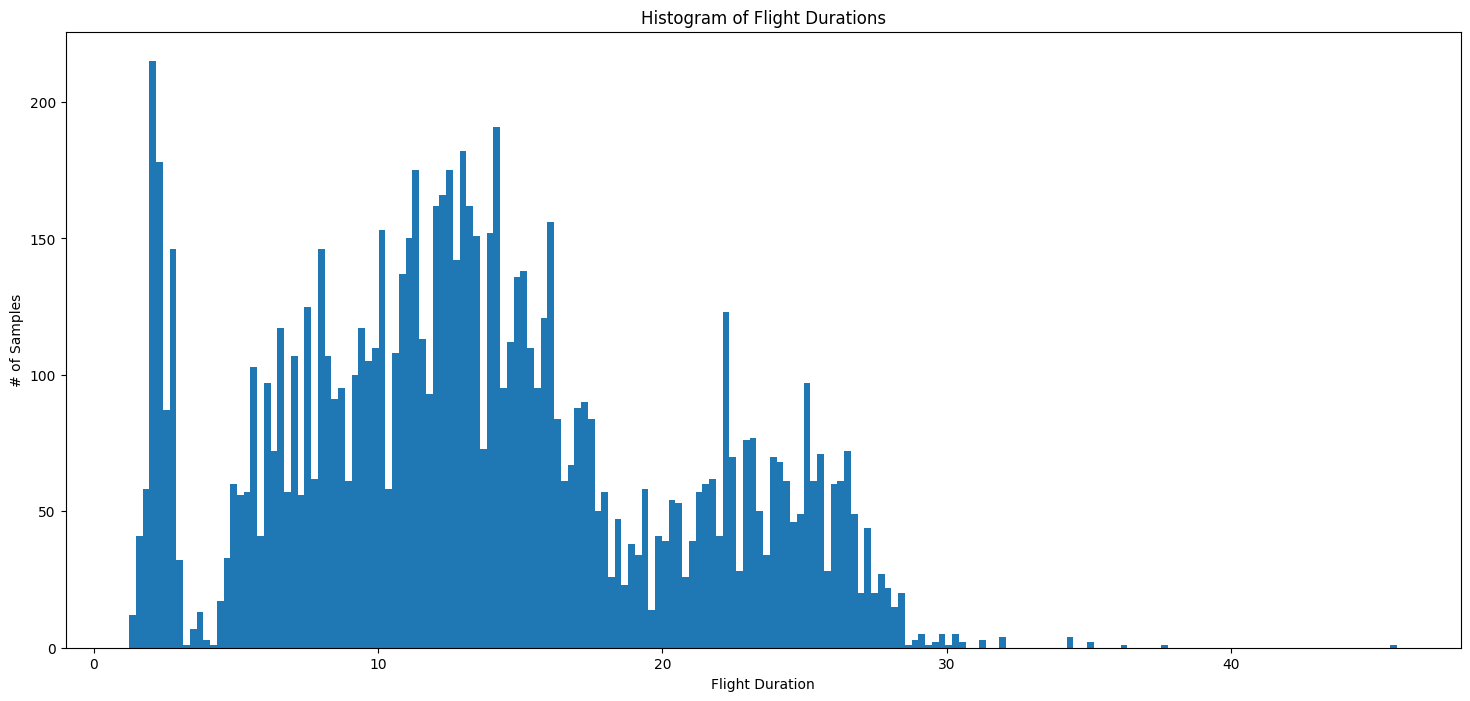

Flight durations ranged from 1.25 to 45.83.


In [9]:
histogram_visual(data['flight_duration'],
                 num_of_bins=188,
                 plot_title="Histogram of Flight Durations",
                 x_label="Flight Duration")

print(f"Flight durations ranged from " + 
      f"{round(min(data['flight_duration']), 2)} to" + 
      f" {round(max(data['flight_duration']), 2)}.")

#### Dataset Visualization: Days Left Until Flight

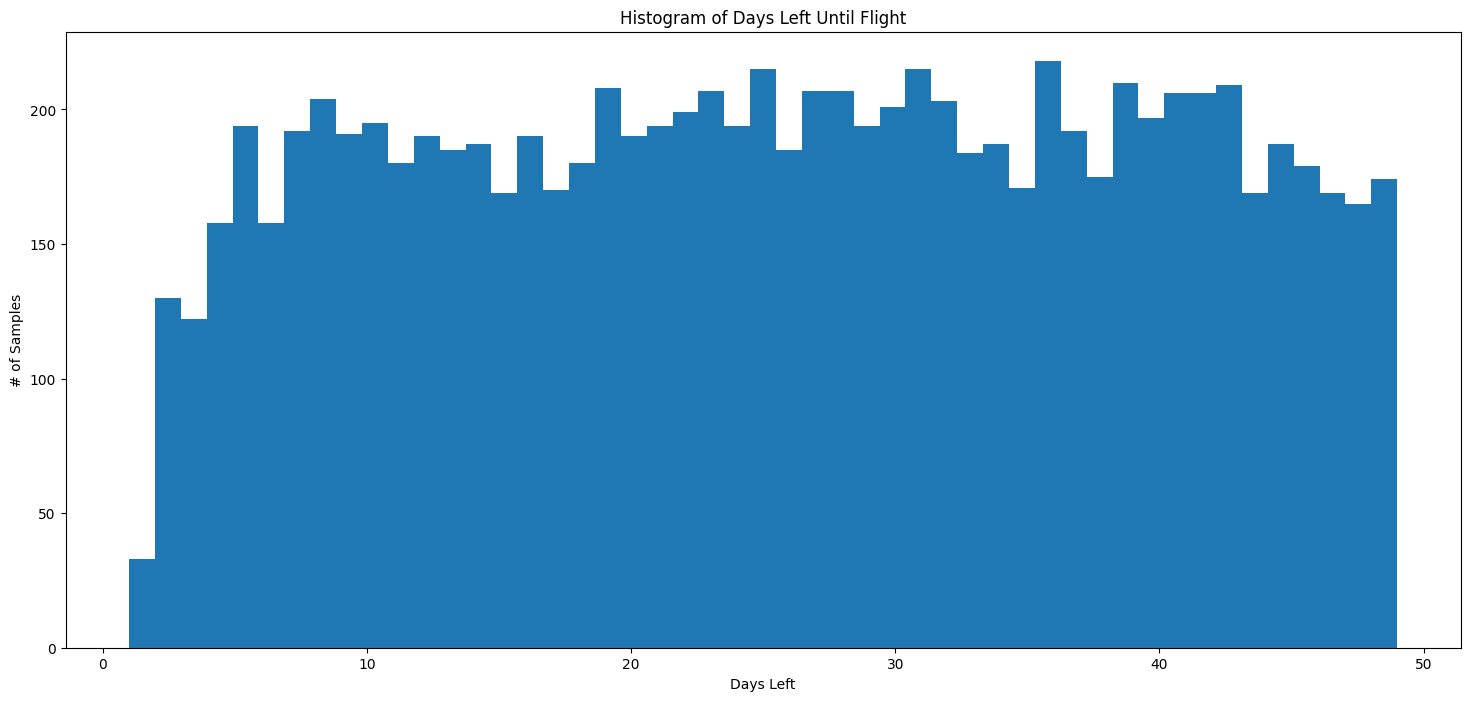

The number of days left until flight ranged from 1 to 49 days.


In [10]:
histogram_visual(data['days_left'],
                 num_of_bins=49,
                 plot_title="Histogram of Days Left Until Flight",
                 x_label="Days Left")

print(f"The number of days left until flight ranged" + 
      f" from {min(data['days_left'])}" + 
      f" to {max(data['days_left'])} days.")

#### Dataset Visualization: Target

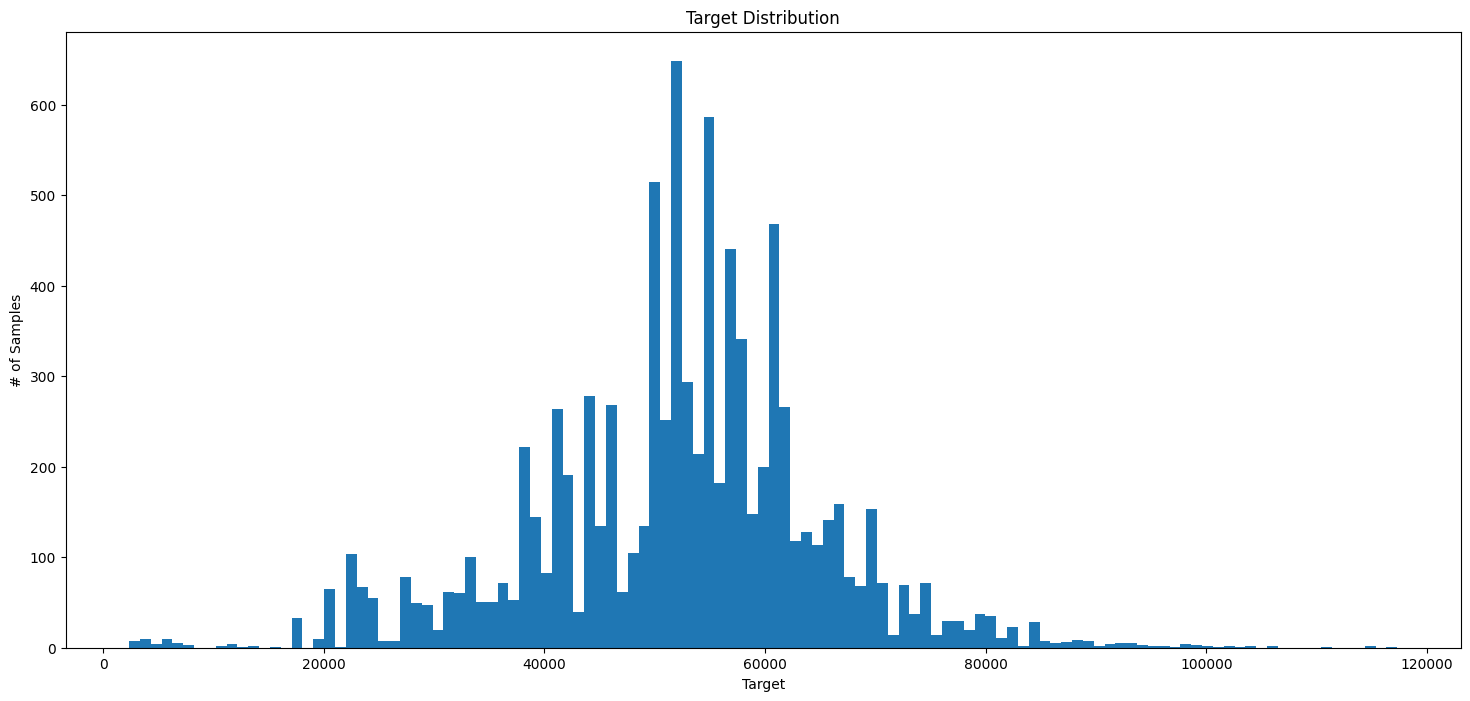

Flight Prices ranged from $2339 to $117307.


In [11]:
histogram_visual(data['target'],
                 num_of_bins=117,
                 plot_title="Target Distribution",
                 x_label="Target")

print(f"Flight Prices ranged from " + 
      f"${min(data['target'])} to" + 
      f" ${max(data['target'])}.")

#### Create Function to Visualize Features (Barplot)

In [12]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: np.int8 = 0,
                   annotation: np.bool_ = True
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    - rotation: The integer value of the rotation of 
        x-tick values
    - 
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.int8, \
        "The rotation value must be an integer value."
    
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(12,8),
                                                      rot=rotation, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red",
                                                             "purple"]
                                                      )
    
    if annotation:
        ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Dataset Visualization: Diabetes

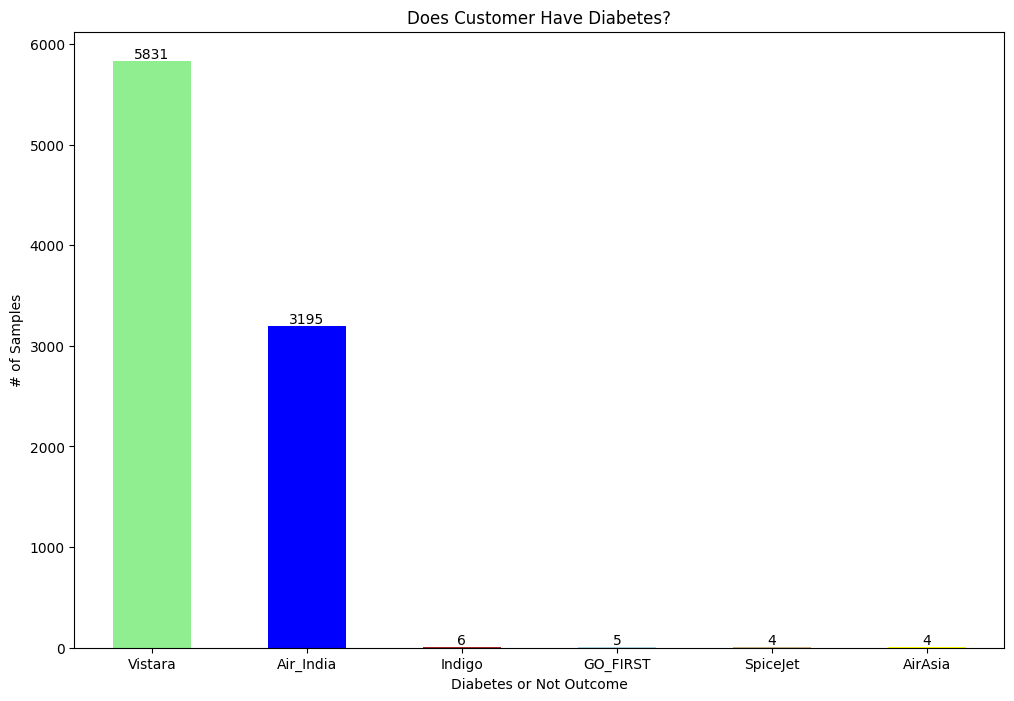

In [13]:
barplot_visual(data["airline"],
               "Does Customer Have Diabetes?",
               "Diabetes or Not Outcome",
               "# of Samples",
               )

#### Dataset Visualization: Blood Pressure Problems

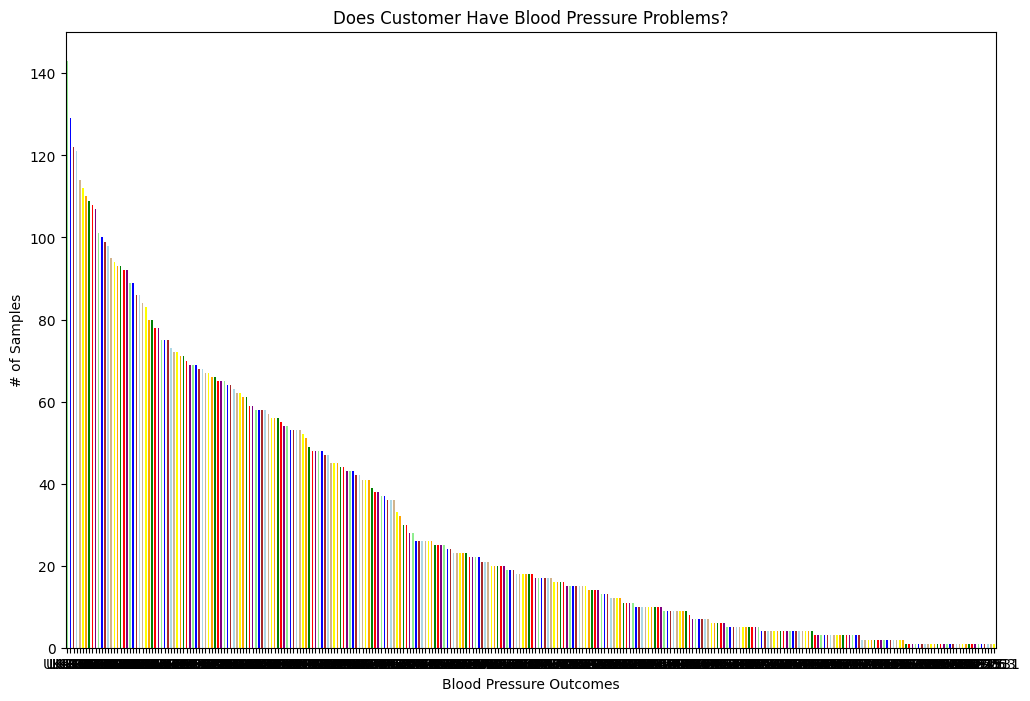

In [14]:
barplot_visual(data["flight"],
               "Does Customer Have Blood Pressure Problems?",
               "Blood Pressure Outcomes",
               "# of Samples",
               annotation=False
               )

#### Dataset Visualization: Any Transplants

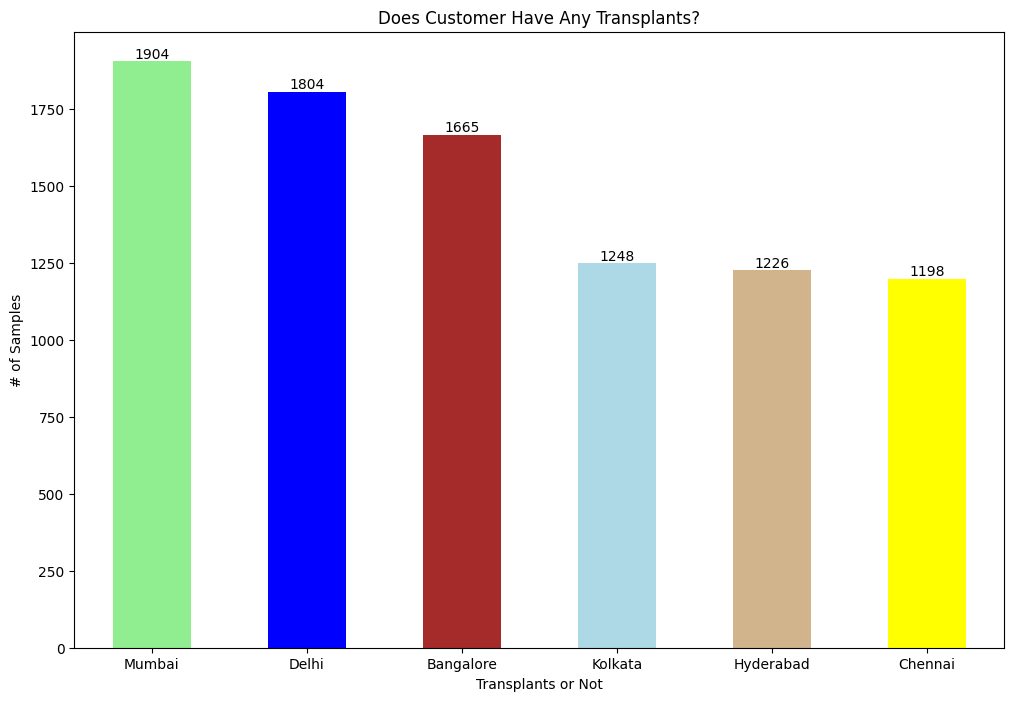

In [15]:
barplot_visual(data["source_city"],
               "Does Customer Have Any Transplants?",
               "Transplants or Not",
               "# of Samples",
               )

#### Dataset Visualization: Any Chronic Diseases

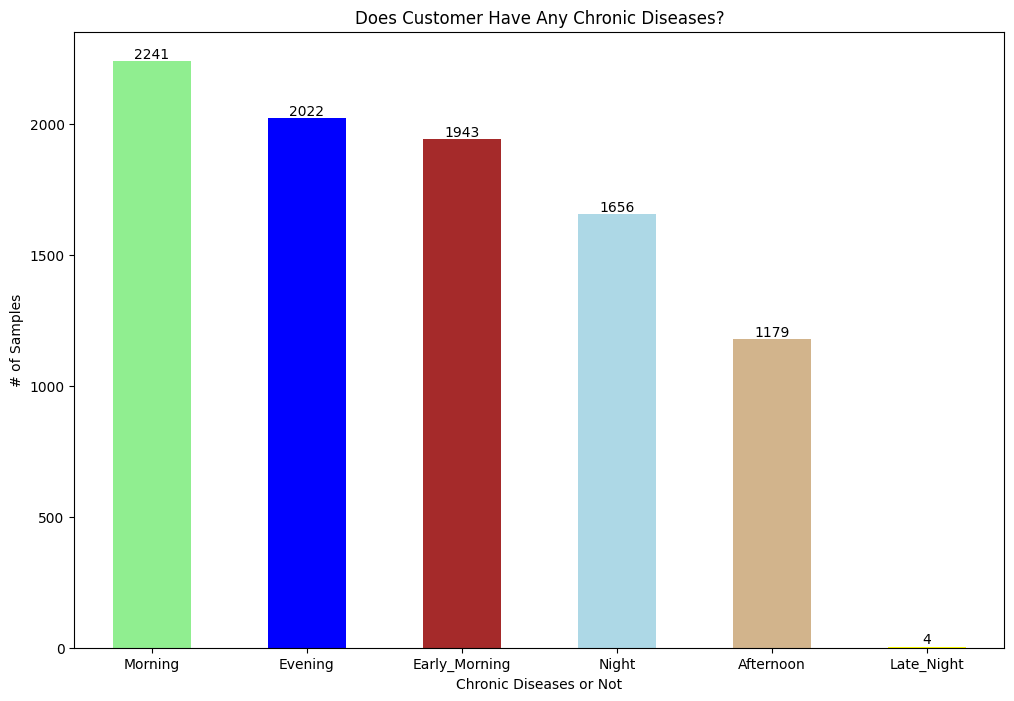

In [16]:
barplot_visual(data["departure_time"],
               "Does Customer Have Any Chronic Diseases?",
               "Chronic Diseases or Not",
               "# of Samples",
               )

#### Dataset Visualization: Known Allergies

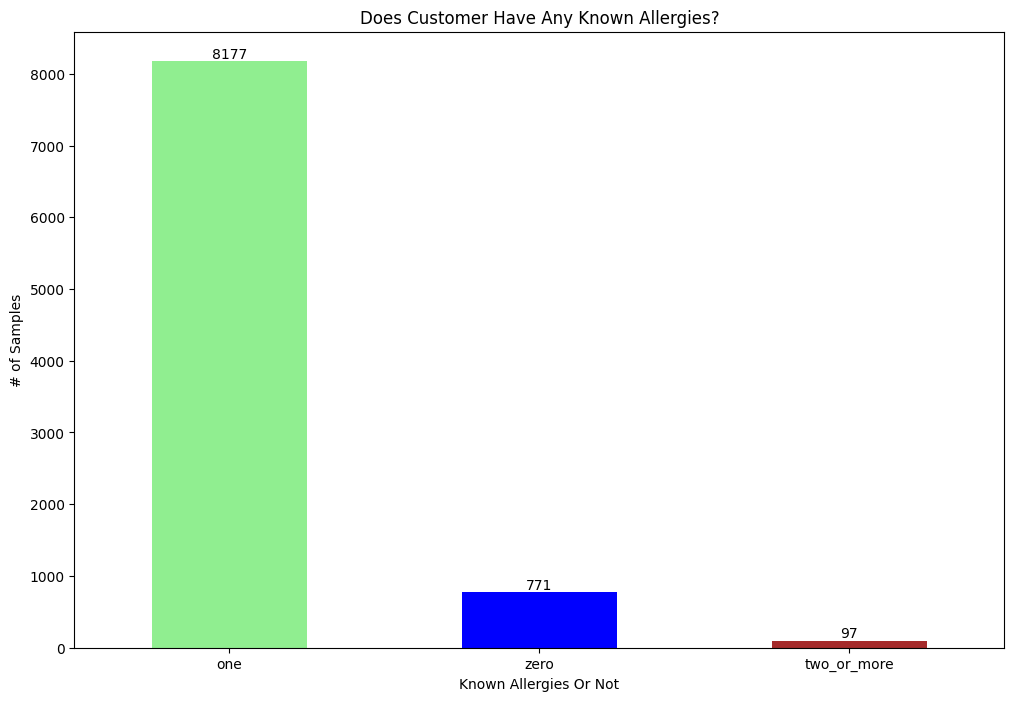

In [17]:
barplot_visual(data["layovers"],
               "Does Customer Have Any Known Allergies?",
               "Known Allergies Or Not",
               "# of Samples",
               )

#### Dataset Visualization: History of Cancer in Family

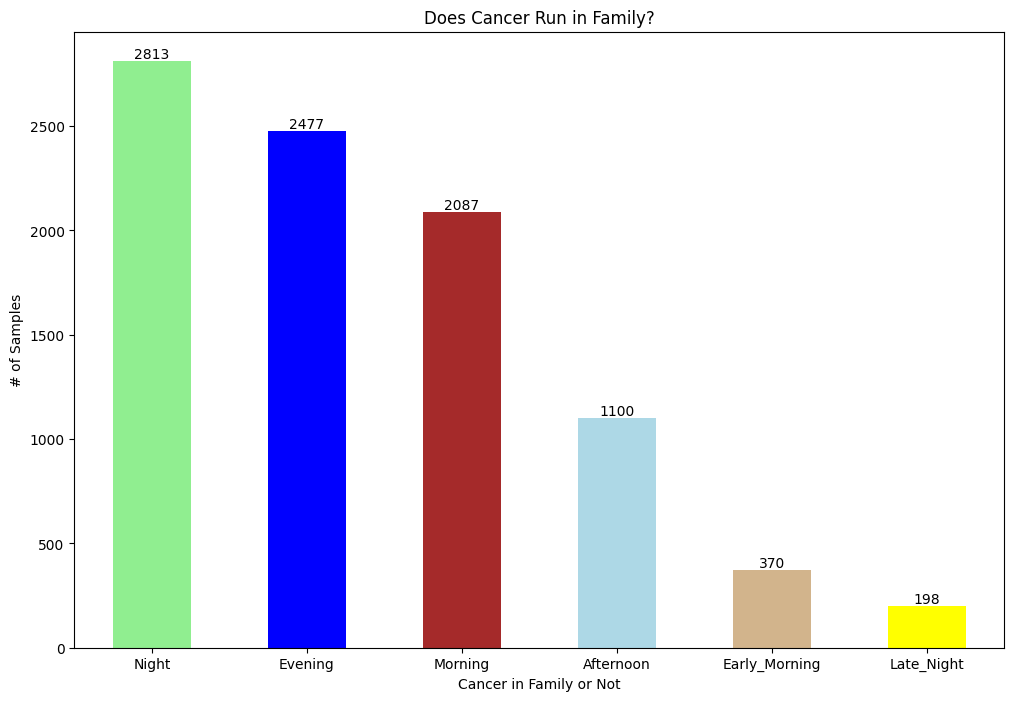

In [18]:
barplot_visual(data["arrival_time"],
               "Does Cancer Run in Family?",
               "Cancer in Family or Not",
               "# of Samples",
               )

#### Dataset Visualization: Number of Major Surgeries

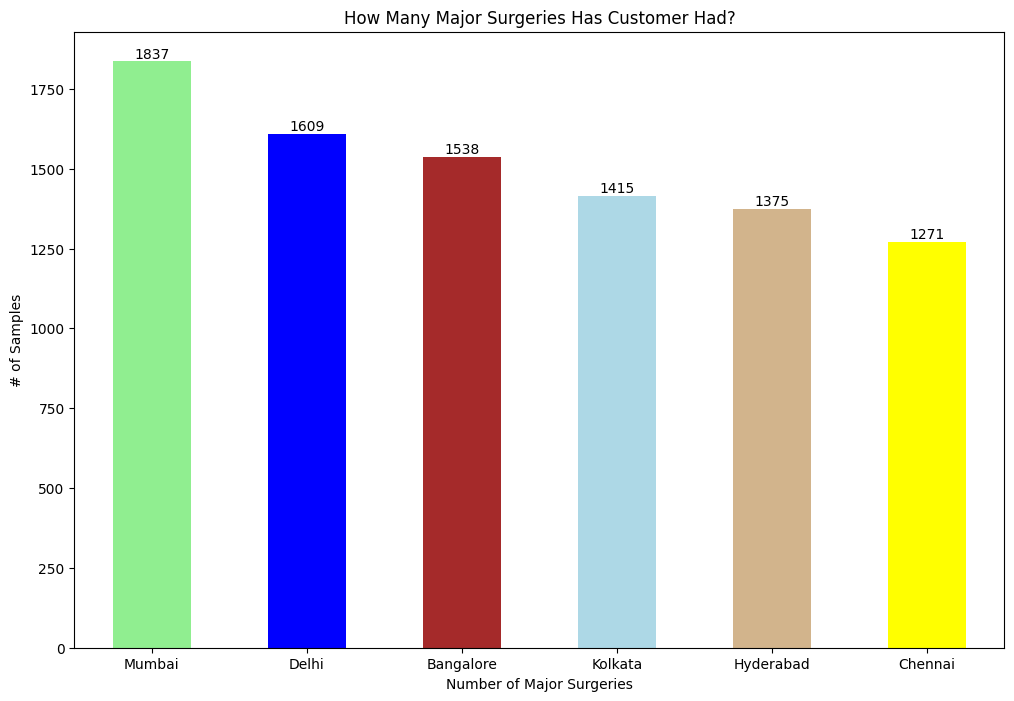

In [19]:
barplot_visual(data["dest_city"],
               "How Many Major Surgeries Has Customer Had?",
               "Number of Major Surgeries",
               "# of Samples",
               )

### Exploratory Data Analysis & Preprocessing

#### Descriptive Statistics

In [20]:
data.describe(percentiles=[0.01, 
                           0.10, 
                           0.25, 
                           0.50, 
                           0.75, 
                           0.90,
                           0.99], 
              include='all'
              )

,airline,flight,source_city,departure_time,layovers,arrival_time,dest_city,flight_duration,days_left,target
count,9045,9045,9045,9045,9045,9045,9045,9045.000000,9045.000000,9045.000000
unique,6,296,6,6,3,6,6,NaN,NaN,NaN
top,Vistara,UK-772,Mumbai,Morning,one,Night,Mumbai,NaN,NaN,NaN
freq,5831,143,1904,2241,8177,2813,1837,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.673429,25.814925,52198.478165
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.839508,13.514093,13179.175493
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.000000,2339.000000
1%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.869600,2.000000,20000.000000
10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.080000,7.000000,35554.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.750000,14.000000,44610.000000


### Prepare Shared Pipeline Data & Stages/Steps

#### Split Dataset into Training & Testing Datasets

In [21]:
y = data['target']
X = data.drop(columns=['target'], axis=1)

print(f"Training Inputs Dataset Shape: {X.shape}")
print(f"Training Outputs Dataset Shape: {y.shape}")

Training Inputs Dataset Shape: (9045, 9)
Training Outputs Dataset Shape: (9045,)


#### Define Column Lists for Transformers (Pipeline Stages) & Transform to Integer Values

In [22]:
numerical_features = ["flight_duration"]

nominal_features = [x for x in data.columns if x not in numerical_features and x != 'target']

nominal_features

['airline',
 'flight',
 'source_city',
 'departure_time',
 'layovers',
 'arrival_time',
 'dest_city',
 'days_left']

#### Remove Outliers

In [23]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, features_to_remove):
    df = pd.DataFrame(df).copy()
    for feat in features_to_remove:
        x = df[feat]
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3-q1
        ul = q3 + (iqr * 1.5)
        ll = q1 - (iqr * 1.5)
        neo_df = df[(df[feat] >= ll) | (df[feat] <= ul)]
    return neo_df

outlier_remover = FunctionTransformer(remove_outliers, 
                                      kw_args={
                                          'features_to_remove': numerical_features
                                          }
                                      )

#### Create Column Transformer

In [24]:
encoder_col_transformer = ColumnTransformer(
    [
        (
            "remove_outliers",
            outlier_remover,
            numerical_features
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown='ignore',
                          dtype=np.float64), 
            nominal_features)
    ], 
    remainder='passthrough')

#### Metrics Evaluation Method

In [25]:
regression_metric_names = ('explained_variance', 
                           'neg_mean_absolute_error', 
                           'neg_root_mean_squared_error', 
                           )

def regression_eval(model_name: str,
                    scores: tuple(),
                    ) -> None:
    '''
    Calculate & display metrics for a regression analysis.
    '''
        
    metrics_titles = ["Explained Variance", 
                      "Mean Absolute Error", 
                      "Root Mean Squared Error", 
                      ]
    
    print("+------------------------------------------------+")
    print("|  " + ("Training " + model_name).center(44) + "  |")
    print("+------------------------------------------------+")
    print("|  %s  |  %s   | " % ("Metric".rjust(29), "Value".ljust(9)))
    print("+------------------------------------------------+")
    for x in range(len(regression_metric_names)):
        
        name = "train_" + regression_metric_names[x]
        
        score = mean(scores[name])
        
        if score < 0:
            score = score * -1
        
        print("| %s  |  %s   |" % (("Train " + metrics_titles[x]).rjust(30), str(round(score, 3)).ljust(9)))
        print("+------------------------------------------------+")
    
    print()
    
    print("+------------------------------------------------+")
    print("|  " + ("Testing " + model_name).center(44) + "  |")
    print("+------------------------------------------------+")
    print("|  %s  |  %s   | " % ("Metric".rjust(29), "Value".ljust(9)))
    print("+------------------------------------------------+")
    for x in range(len(regression_metric_names)):
        name = "test_" + regression_metric_names[x]
        score = mean(scores[name])
        
        if score < 0:
            score = score * -1
        
        print("| %s  |  %s   |" % (("Test " + metrics_titles[x]).rjust(30), str(round(score, 3)).ljust(9)))
        print("+------------------------------------------------+")

### SVM Regression (SVR)

#### Define Pipeline

In [26]:
def svm_regression():
    """
    This function creates the SVM Regression.
    """
    svmr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler(with_mean=False)
            ),
            (
                'svm_reg', 
                SVR(kernel='poly', 
                    degree=9,
                    C=0.95
                    )
             ),
        ]
    )
    
    return svmr_pipe

#### Define Model

In [27]:
svmr = svm_regression()

svmr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'svm_reg': SVR(C=0.95, degree=9, kernel='poly')}

#### Fit Algorithm to Dataset

In [28]:
svmr_scores = cross_validate(svmr, 
                        X, 
                        y, 
                        cv=10,
                        n_jobs=4,
                        scoring=regression_metric_names,
                        return_train_score=True)

#### Metrics Evaluation

In [29]:
regression_eval("SVM Regression", 
               svmr_scores)

+------------------------------------------------+
|            Training SVM Regression             |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.105       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  8937.71     |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  12482.88    |
+------------------------------------------------+

+------------------------------------------------+
|             Testing SVM Regression             |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.061       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  9234.353    |
+---------------------------

### ElasticNet Regression

#### Define Pipeline

In [30]:
def elastic_net_regression():
    """
    This function creates the ElasticNet Regression.
    """
    en_reg_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                'scaler', 
                StandardScaler(with_mean=False),
            ),
            (
                'elastic_net_reg', 
                ElasticNet(random_state=42, 
                           max_iter=2000, 
                           alpha=0.01
                           )
             ),
        ]
    )
    
    return en_reg_pipe

#### Define Model

In [31]:
enr = elastic_net_regression()

enr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'elastic_net_reg': ElasticNet(alpha=0.01, max_iter=2000, random_state=42)}

#### Fit Algorithm to Dataset

In [32]:
enr_scores = cross_validate(enr, 
                           X, 
                           y, 
                           n_jobs=-1,
                           scoring=regression_metric_names,
                           return_train_score=True)

#### Metrics Evaluation

In [33]:
regression_eval("ElasticNet Regression", 
                       enr_scores)

+------------------------------------------------+
|         Training ElasticNet Regression         |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.74        |
+------------------------------------------------+
|      Train Mean Absolute Error  |  4583.265    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  6722.595    |
+------------------------------------------------+

+------------------------------------------------+
|         Testing ElasticNet Regression          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.708       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  4856.35     |
+---------------------------

### Kernel Ridge Regression

#### Define Pipeline

In [34]:
def kernel_ridge_regression():
    """
    This function creates the Kernel Ridge Regression.
    """
    kernel_ridge_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler(with_mean=False)
            ),
            (
                'kernel_ridge_reg', 
                KernelRidge(kernel='poly')
             ),
        ]
    )
    
    return kernel_ridge_pipe

#### Define Model

In [35]:
kr_reg = kernel_ridge_regression()

kr_reg.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'kernel_ridge_reg': KernelRidge(kernel='poly')}

#### Fit Algorithm to Dataset

In [36]:
kr_reg_scores = cross_validate(kr_reg, 
                              X, 
                              y, 
                              n_jobs=-1,
                              scoring=regression_metric_names,
                              return_train_score=True)

#### Metrics Evaluation

In [37]:
regression_eval("Kernel Ridge Regression", 
                       kr_reg_scores)

+------------------------------------------------+
|        Training Kernel Ridge Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.906       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  2357.875    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  4041.365    |
+------------------------------------------------+

+------------------------------------------------+
|        Testing Kernel Ridge Regression         |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.768       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  3857.592    |
+---------------------------

### Random Forest Regression

#### Define Pipeline

In [38]:
def random_forest_regression():
    """
    This function creates the Random Forest Regression.
    """
    rfr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer),
            (
                "scaler",
                StandardScaler(with_mean=False)
            ),
            (
                'random_forest_regressor', 
                RandomForestRegressor(random_state=42,
                                      criterion='poisson', 
                                      n_estimators=125,
                                      max_depth=18
                                      )
             ),
        ]
    )
    
    return rfr_pipe

#### Define Model

In [39]:
rfr = random_forest_regression()

rfr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'random_forest_regressor': RandomForestRegressor(criterion='poisson', max_depth=18, n_estimators=125,
                       random_state=42)}

#### Fit Classifier to Dataset

In [40]:
rfr_scores = cross_validate(rfr, 
                              X, 
                              y, 
                              n_jobs=-1,
                              cv=10,
                              scoring=regression_metric_names,
                              return_train_score=True)

#### Evaluation Metrics

In [41]:
regression_eval("Random Forest Regression", 
                rfr_scores)

+------------------------------------------------+
|       Training Random Forest Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.91        |
+------------------------------------------------+
|      Train Mean Absolute Error  |  2399.323    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  3949.743    |
+------------------------------------------------+

+------------------------------------------------+
|        Testing Random Forest Regression        |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.797       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  3375.927    |
+---------------------------

### SGD Regression

#### Define Pipeline

In [42]:
def sgd_regression():
    """
    This function creates the Random Forest Regression.
    """
    sgdr_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler(with_mean=False)
            ),
            (
                'stochastic_gradient_descent_regressor', 
                SGDRegressor(random_state=42,
                             loss='huber',
                             penalty='l2',
                             alpha=0.0001,
                             l1_ratio=0.50,
                             max_iter=2500,
                             learning_rate='invscaling',
                             eta0=2.5,
                             power_t=0.01
                             )
             ),
        ]
    )
    
    return sgdr_pipe

#### Fit Model

In [43]:
sgdr = sgd_regression()

sgdr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'stochastic_gradient_descent_regressor': SGDRegressor(eta0=2.5, l1_ratio=0.5, loss='huber', max_iter=2500, power_t=0.01,
              random_state=42)}

#### Fit Classifier to Dataset

In [44]:
sgdr_scores = cross_validate(sgdr, 
                              X, 
                              y, 
                              n_jobs=-1,
                              cv=10,
                              scoring=regression_metric_names,
                              return_train_score=True)

#### Evaluation Metrics

In [45]:
regression_eval("Stochastic Grad. Descent Regression", 
                       sgdr_scores)

+------------------------------------------------+
|  Training Stochastic Grad. Descent Regression  |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.222       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  17975.291   |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  21001.937   |
+------------------------------------------------+

+------------------------------------------------+
|  Testing Stochastic Grad. Descent Regression   |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.222       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  17988.641   |
+---------------------------

### AdaBoost Regression

#### Define Pipeline

In [46]:
def adaboost_regression():
    """
    This function creates the AdaBoost Regression.
    """
    adab_pipe = Pipeline(
        [
            (
                'encoder_column_transformer', 
                encoder_col_transformer
            ),
            (
                "scaler",
                StandardScaler(with_mean=False)
            ),
            (
                'ada_boost_reg', 
                AdaBoostRegressor(
                    random_state=42,
                    estimator=RandomForestRegressor(
                        max_depth=10
                        ),
                    loss='exponential'
                    )
             ),
        ]
        )
    
    return adab_pipe

#### Fit Model

In [47]:
adabr = adaboost_regression()

adabr.named_steps

{'encoder_column_transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('remove_outliers',
                                  FunctionTransformer(func=<function remove_outliers at 0x7f9cb9a30820>,
                                                      kw_args={'features_to_remove': ['flight_duration']}),
                                  ['flight_duration']),
                                 ('ohe', OneHotEncoder(handle_unknown='ignore'),
                                  ['airline', 'flight', 'source_city',
                                   'departure_time', 'layovers', 'arrival_time',
                                   'dest_city', 'days_left'])]),
 'scaler': StandardScaler(with_mean=False),
 'ada_boost_reg': AdaBoostRegressor(estimator=RandomForestRegressor(max_depth=10),
                   loss='exponential', random_state=42)}

#### Fit Classifier to Dataset

In [48]:
adabr_scores = cross_validate(adabr, 
                           X, 
                           y, 
                           n_jobs=-1,
                           cv=10,
                           scoring=regression_metric_names,
                           return_train_score=True)

#### Evaluation Metrics

In [49]:
regression_eval("AdaBoost Regression", 
                       adabr_scores)

+------------------------------------------------+
|          Training AdaBoost Regression          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.684       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  6102.844    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  7558.291    |
+------------------------------------------------+

+------------------------------------------------+
|          Testing AdaBoost Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.602       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  6488.708    |
+---------------------------

### Stacking Regression

#### Define Estimators

In [50]:
estimators = [
    (
        'random_forest_reg',
        rfr
    ),
    (
        'adaboost_reg',
        adabr
    )
]

#### Fit Model

In [51]:
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=KernelRidge(kernel='poly'),
    n_jobs=-1
)

#### Fit Classifier to Training Dataset

In [52]:
stacking_scores = cross_validate(stacking_reg, 
                              X, 
                              y, 
                              n_jobs=-1,
                              cv=10,
                              scoring=regression_metric_names,
                              return_train_score=True)

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular ma

#### Regression Metrics Evaluation

In [53]:
regression_eval("Stacking Regression", 
                       stacking_scores)

+------------------------------------------------+
|          Training Stacking Regression          |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.891       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  2982.649    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  4362.731    |
+------------------------------------------------+

+------------------------------------------------+
|          Testing Stacking Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.774       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  3963.489    |
+---------------------------

### Voting Regression

#### Define Estimators

In [54]:
estimators = [
    (
        'random_forest_reg',
        rfr
    ),
    (
        'adaboost_reg',
        adabr
    )
]

#### Fit Model

In [55]:
voting_clf = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)

#### Fit Classifier to Training Dataset

In [56]:
voting_scores = cross_validate(voting_clf, 
                              X, 
                              y, 
                              n_jobs=-1,
                              cv=10,
                              scoring=regression_metric_names,
                              return_train_score=True)

#### Metrics Evaluation

In [57]:
regression_eval("Voting Regression", 
                       voting_scores)

+------------------------------------------------+
|           Training Voting Regression           |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|       Train Explained Variance  |  0.839       |
+------------------------------------------------+
|      Train Mean Absolute Error  |  4111.298    |
+------------------------------------------------+
|  Train Root Mean Squared Error  |  5335.937    |
+------------------------------------------------+

+------------------------------------------------+
|           Testing Voting Regression            |
+------------------------------------------------+
|                         Metric  |  Value       | 
+------------------------------------------------+
|        Test Explained Variance  |  0.742       |
+------------------------------------------------+
|       Test Mean Absolute Error  |  4747.669    |
+---------------------------

### Notes & Other Takeaways From This Project
****
- The model with the best raw metrics (without considering overfitting) was the random forest regression.
- When trying to reduce overfitting, the best result was the ElasticNet model. While the raw metrics were not as good as the random forest regression model, there was far less overfitting.
****